In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os
os.chdir('./1-4/')
from lr_utils import load_dataset

In [2]:
# import dataset
X_train, Y_train, X_test, Y_test, classes = load_dataset()
X_train = X_train.reshape((X_train.shape[0], -1)).T / 255
X_test = X_test.reshape((X_test.shape[0], -1)).T / 255
print(f'X_train.shape = {X_train.shape}')
print(f'X_test.shape = {X_test.shape}')
print(f'Y_train.shape = {Y_train.shape}')
print(f'Y_test.shape = {Y_test.shape}')

X_train.shape = (12288, 209)
X_test.shape = (12288, 50)
Y_train.shape = (1, 209)
Y_test.shape = (1, 50)


In [3]:
#  I have already implement model 'Layer' and 'Model' in practice 1-3

def tanh(x):
    s = np.tanh(x)
    return s

def sigmoid(x):
    s = 1 / (1 + np.exp(-x))
    return s

def ReLU(x):
    s = np.maximum(x, 0)
    return s


class Layer(object):
    '''
    implement general Layer which can fowardpropagate and 
    backpropagate with parameters like W,b and so on as it's
    attributes.

    initial parameters of a Layer instance：

    n_input: int, number of input features
    n_layer: int, number of layer units
    activate: function, chose from [tanh, sigmoid, ReLU]
    name: str, default None, optional
    '''
    def __init__(self, n_input, n_layer, activate, name=None):
        self.n = n_layer
        self.name = name
        self.activate = activate
        self.X = None
        # self.W = np.random.randn(n_layer, n_input) * 1e-4
        self.W = np.random.randn(n_layer, n_input) * np.sqrt(2 / n_input)
        self.b = np.zeros((n_layer, 1))
        self.Z = None
        self.A = None
        self.dA = None
        self.dZ = None
        self.dW = None
        self.db = None
        self.dX = None

    def get_W(self):
        return self.W

    def get_b(self):
        return self.b

    def get_A(self):
        return self.A

    def get_dX(self):
        return self.dX    

    def fwprop(self, X):
        self.X = X
        self.Z = np.dot(self.W, self.X) + self.b
        self.A = self.activate(self.Z)

    def bkprop(self, dA, alpha):
        self.dA = dA
        if self.activate == tanh:
            self.dZ = self.dA * (1 - self.A**2)
        elif self.activate == sigmoid:
            self.dZ = self.dA * self.A * (1 - self.A)
        elif self.activate == ReLU:
            self.dZ = self.dA * (self.A > 0)
        else:
            print('Wrong activate function!')
        self.dX = np.dot(self.W.T, self.dZ)
        self.dW = np.dot(self.dZ, self.X.T)
        self.db = np.mean(self.dZ, axis=1).reshape((self.n, 1))
        self.W -= alpha * self.dW
        self.b -= alpha * self.db



class Model(object):
    '''
    implement general Model which can add layer, fowardpropagate, compute 
    cost, backpropagate, train, predict and score.

    layer list can be found in the attribute Model.layers.
    
    parameters like W,b can be found in attributes of layers in the
    layer list.

    initial parameters of a Model instance：

    X_train: np.ndarray, input of training data
    Y_train: np.ndarray, output of training data
    alpha: float, learning rate, default to be 0.005
    loops: int, number of iteration you want to train, default 2000
    '''
    def __init__(self, X_train, Y_train, alpha=0.005, loops=2000):
        self.X = X_train
        self.Y = Y_train
        self.alpha = alpha
        self.loops = loops
        self.L = 0
        self.layers = []
        self.layers_reverse = []
        self.A = None
        self.J = None
        self.J_list = []

    def add_layer(self, n_input, n_layer, activate, name=None):
        self.L += 1
        new_layer = Layer(n_input, n_layer, activate, name=name)
        self.layers.append(new_layer)
        self.layers_reverse = self.layers.copy()
        self.layers_reverse.reverse()
        return new_layer

    def fwprop(self):
        input_ = self.X
        for layer in self.layers:
            layer.fwprop(input_)
            input_ = layer.get_A()

    def compute_J(self):
        self.A = self.layers[-1].get_A()
        # 防止出现log(0)等于nan的情况, 每次log()内加上极小正数
        self.J = (-self.Y * np.log(self.A + 1e-10) - (1 - self.Y) * np.log(1 - self.A + 1e-10)).mean()

    def bkprop(self):
        # 防止出现x / 0等于nan的情况, 每次 / 分母加上极小正数
        dA = -self.Y / (self.A +10e-10) + (1 - self.Y) / (1 - self.A +10e-10)
        for layer in self.layers_reverse:
            layer.bkprop(dA, alpha=self.alpha)
            dA = layer.get_dX()

    def train(self):
        for i in range(self.loops):
            self.fwprop()
            self.compute_J()
            self.bkprop()
            self.J_list.append(self.J)
            j = i + 1
            if j%50 == 0:
                print(f'loss of iteration No.{j}: {self.J}')

    def predict(self, X_test):
        for layer in self.layers:
            layer.fwprop(X_test)
            X_test = layer.get_A()
        return X_test

    def score(self, X_test, Y_test):
        Y_predict = self.predict(X_test)
        result = (Y_predict > 0.5) == Y_test
        acc = result.mean()
        return acc

    def plot_loss(self):
        plt.plot(self.J_list)
        plt.xlabel('step')
        plt.ylabel('loss')
        plt.title('loss circle')
        plt.show()


In [4]:
model_2l = Model(X_train, Y_train, alpha=0.00001, loops=2000)
model_2l.add_layer(12288, 7, ReLU, name='hiden layer with 7 units')
model_2l.add_layer(7, 1, sigmoid, name='output layer')
model_2l.train()

loss of iteration No.50: 0.6232150757921674
loss of iteration No.100: 0.6029610247058244
loss of iteration No.150: 0.5861004013730786
loss of iteration No.200: 0.5716324909948473
loss of iteration No.250: 0.5584637908942244
loss of iteration No.300: 0.5459454990588168
loss of iteration No.350: 0.5338637501822505
loss of iteration No.400: 0.5221939389580211
loss of iteration No.450: 0.5108765551044074
loss of iteration No.500: 0.4999054449791161
loss of iteration No.550: 0.4891374435223103
loss of iteration No.600: 0.47852430050069167
loss of iteration No.650: 0.468005966323482
loss of iteration No.700: 0.45762801253356816
loss of iteration No.750: 0.4472852451787561
loss of iteration No.800: 0.43708460153475404
loss of iteration No.850: 0.4269808965711449
loss of iteration No.900: 0.4170124921743375
loss of iteration No.950: 0.40718337834375096
loss of iteration No.1000: 0.3974859297991283
loss of iteration No.1050: 0.3879497966346807
loss of iteration No.1100: 0.3784904034814847
loss 

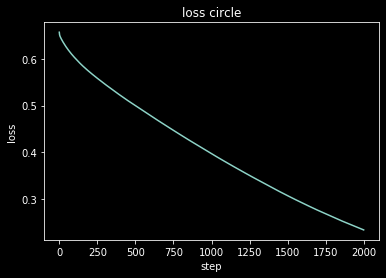

In [5]:
model_2l.plot_loss()

In [6]:
print('final loss:', model_2l.J)
print('the 2 Lyaers model\'s accuracy:', model_2l.score(X_test, Y_test))
# alpha=0.00001 still have vibration between 500 and 1300 iteration ,
# maybe try a smaller alpha can be better , however loss can be smaller if training on, but enough
# compare with practice 1-2 , model_2l get a better loss but better accuracy on test data

final loss: 0.23469474339395904
the 2 Lyaers model's accuracy: 0.72


In [7]:
model_4l = Model(X_train, Y_train, alpha=0.05, loops=1500)
model_4l.add_layer(12288, 20, ReLU, name='hiden layer 1 with 20 units active by ReLU')
model_4l.add_layer(20, 7, ReLU, name='hiden layer 2 with 7 units active by ReLU')
model_4l.add_layer(7, 5, ReLU, name='hiden layer 3 with 5 units active by ReLU')
model_4l.add_layer(5, 1, sigmoid, name='output layer active by sigmoid')
model_4l.train()

loss of iteration No.50: 7.932350559531162
loss of iteration No.100: 7.932350559531162
loss of iteration No.150: 7.932350559531162
loss of iteration No.200: 7.932350559531162
loss of iteration No.250: 7.932350559531162
loss of iteration No.300: 7.932350559531162
loss of iteration No.350: 7.932350559531162
loss of iteration No.400: 7.932350559531162
loss of iteration No.450: 7.932350559531162
loss of iteration No.500: 7.932350559531162
loss of iteration No.550: 7.932350559531162


KeyboardInterrupt: 

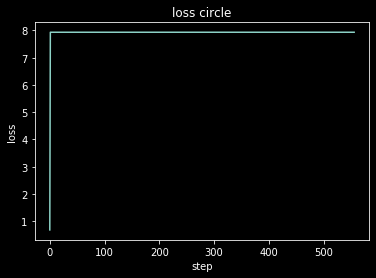

In [10]:
model_4l.plot_loss()

In [0]:
print('final loss:', model_4l.J)
print('the 4 Lyaers model\'s accuracy:', model_4l.score(X_test, Y_test))